### Problem Set 3:
   Tom Curran
   
   MAC30100 Winter 2018
   
   January 24, 2018
   
#### Question 1

Some income data, lognormal distribution, and GMM (7 points). For this problem, you will use the same 200 data points from Problem Set 2 of annual incomes of students who graduated in 2018, 2019, and 2020 from the University of Chicago M.A. Program in Computational Social Science. These data are in a single column of the text file incomes.txt in the PS3 folder. Incomes are reported in U.S. dollars. For this exercise, you will need to use the log normal distribution.

$$f(x | \mu, \sigma) = \frac{1}{x\sigma\sqrt{2\pi}} * e^{(-\frac{[ln(x)-\mu]^2}{2\sigma^2})} $$

The function $f(x|\mu, \sigma^2)$ is a probability density function in that $f(x|\mu, \sigma^2)>0$for all x and  $f(x|\mu, \sigma^2) = 1$. Note that $x$ must be nonnegative in the lognormal distribution and σ must be strictly positive.


In [1]:
import numpy as np
import pandas as pd
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

incomesdf = pd.read_csv("incomes.txt", header = None).rename(columns = {0:'Income'})

incomes = incomesdf.Income

incomesdf.info()

incomesdf.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 1 columns):
Income    200 non-null float64
dtypes: float64(1)
memory usage: 1.6 KB


,Income
count,200.000000
mean,87588.930769
std,18081.166388
min,49278.801938
25%,74088.607447
50%,85801.697366
75%,100102.725206
max,135865.026796


a) Plot a histogram of percentages of the income.txt data with 30 bins. Make sure that the bins are weighted using the normed=True option. Make sure your plot has correct x-axis and y-axis labels as well as a plot title.

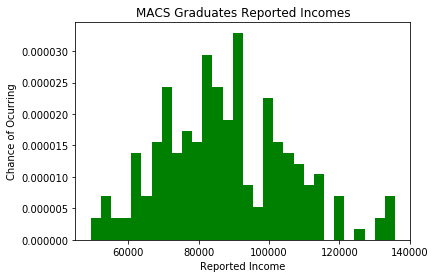

In [2]:
plt.hist(incomes, bins = 30, normed = 30, color = 'g')
plt.title("MACS Graduates Reported Incomes")
plt.xlabel("Reported Income")
plt.ylabel("Chance of Ocurring")

In [3]:
def lognormalpdf(x, mu, sigma, cutoff):
    #taken from homework assignment on github
    pdf = (1/(x *sigma * np.sqrt(2 * np.pi)) * np.exp( - (np.log(x) - mu)**2 / (2 * sigma**2)))
    
    return(pdf)

In [4]:
def dataMoments(x):
    x_mean = x.mean()
    x_std = x.std()
    
    return x_mean, x_std

In [5]:
def modelMoments(mu, sigma, cutoff):
    xfx = lambda x: x * lognormalpdf(x, mu, sigma, cutoff)
    
    (mean_model, m_m_err) = intgr.quad(xfx, 0, cutoff)
    
    x2fx = lambda x: ((x - mean_model) ** 2) * lognormalpdf(x, mu, sigma, cutoff) 
    
    #adding np.sqrt() to original code since the standard error is the square root of the var
    (std_model, v_m_err) = np.sqrt(intgr.quad(x2fx, 0, cutoff))
    return(mean_model, std_model)

In [6]:
def errors1(x, mu, sigma, cutoff, simple):
    #returns the mean and variance of the original (x) list
    x_mean, x_std = dataMoments(x)
    
    data_moments = np.array([[x_mean], [x_std]])
   
    model_mean, model_std = modelMoments(mu, sigma, cutoff)
    
    model_moments = np.array([[model_mean], [model_std]])
    
    if simple:
        errorVector = model_moments - data_moments
    else:
        errorVector = (model_moments - data_moments) / data_moments
    
    return(errorVector)

In [7]:
def criterion(params, *args):
    mu, sigma = params
    x, cutoff, W = args
    err = errors1(x, mu, sigma, cutoff, simple=False)
    critical_value = np.dot(np.dot(err.T, W), err)    
    return critical_value

In [36]:
mu_init = 11.5

sigma_init = .5

params_init = np.array([mu_init, sigma_init])

cutoff = 150000

w_hat = np.eye(2)

moment_args = (incomes, cutoff, w_hat)

results = opt.minimize(criterion, 
                       params_init, 
                       args=(moment_args),
                       method='L-BFGS-B', 
                       bounds=((1e-10, None), (1e-10, None)))

Estimate the parameters of the lognormal distribution by generalized method of moments. Use the average income and standard deviation of income as your two moments. Use the identity matrix as your weighting matrix Wˆ .

Plot your estimated lognormal PDF against the histogram from part (a).

Report the value of your GMM criterion function at the estimated parameter values. 

Report and compare your two data moments against your two model moments at the estimated parameter values.

In [9]:
results

      fun: array([[  4.54980191e-15]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  9.98192748e-08,   7.22448416e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 39
      nit: 9
   status: 0
  success: True
        x: array([ 11.36610095,   0.20935994])

In [10]:
gmm_mu1, gmm_sigma1 = results.x
print("GMM Mu: ", gmm_mu1)
print('-----------------------------')
print("GMM Sigma: ", gmm_sigma1)

GMM Mu:  11.3661009481
-----------------------------
GMM Sigma:  0.209359943669


In [11]:
#data moments
data_mean, data_std = dataMoments(incomes)
print("Data Mu: ", data_mean)
print('-----------------------------')
print("Data Standard Deviation: ", data_std)

Data Mu:  87588.93076851233
-----------------------------
Data Standard Deviation:  18081.166388410416


In [12]:
#mean and std of model:
model_mean, model_std= modelMoments(gmm_mu1, gmm_sigma1, 150000)

print("Model Mean: ",model_mean )
print('-----------------------------')
print("Model Standard Deviaiton: ", model_std)

Model Mean:  87588.93068826331
-----------------------------
Model Standard Deviaiton:  18081.1676079


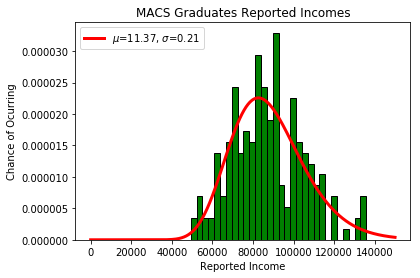

In [13]:
x_sim = np.linspace(0.01, 150000, 20000)
x_sim_pdf = lognormalpdf(x_sim, gmm_mu1, gmm_sigma1, cutoff)
plt.hist(incomes, bins = 30, normed = 30, color = 'g', edgecolor = 'black')
plt.title("MACS Graduates Reported Incomes")
plt.xlabel("Reported Income")
plt.ylabel("Chance of Ocurring")
plt.plot(x_sim, x_sim_pdf, linewidth = 3, color = 'r', label='$\mu$=11.37, $\sigma$=0.21' )
plt.legend(loc = 'upper left')

c) Perform the two-step GMM estimator by using your estimates from part (b) with two moments to generate an estimator for the variance covariance matrix Ωˆ2step, which you then use to get the two-step estimator for the optimal weighting matrix Wˆ2step. 

Report your estimates as well as the criterion function value at these estimates. 

Plot your estimated lognormal PDF against the histogram from part (a) and the estimated PDF from
part (b). 

Report and compare your two data moments against your two model moments at the estimated parameter values.

In [15]:
#errors1(x, mu, sigma, cutoff, simple)
error1 = errors1(incomes, gmm_mu1, gmm_sigma1, cutoff, False)
print("critical values of error functions: ", error1)
print("----------------------------------------------")

varcovmatrix = np.dot(error1, error1.T)/incomes.shape[0]
print("Variance Covariance Matrix:")
print(varcovmatrix)

print("----------------------------------------------")
print("Two Step Optimal Weighting Matrix: ")
w_hat2 = lin.pinv(varcovmatrix)
print(w_hat2)

critical values of error functions:  [[ -9.16200531e-10]
 [  6.74459968e-08]]
----------------------------------------------
Variance Covariance Matrix:
[[  4.19711707e-21  -3.08970290e-19]
 [ -3.08970290e-19   2.27448124e-17]]
----------------------------------------------
Two Step Optimal Weighting Matrix: 
[[  8.11009792e+12  -5.97023926e+14]
 [ -5.97023926e+14   4.39498477e+16]]


In [16]:
gmm_params = np.array([gmm_mu1, gmm_sigma1])

gmm_args = (incomes, 150000, w_hat2)

results2 = opt.minimize(criterion, gmm_params, args = (gmm_args),method='L-BFGS-B', bounds=((0.1, None), (0.1, None)))

gmm_mu2, gmm_sigma2 = results2.x

print("GMM Mu #2: ", gmm_mu2)
print('-----------------------------')
print("GMM Sigma #2: ", gmm_sigma2)

params_crit2 = np.array([gmm_mu2, gmm_sigma1])
criterion2 = criterion(params_crit2, incomes, cutoff, w_hat2)

print('-----------------------------')
print("Critical Value, GMM Mu #2, GMM Sigma #2: ", criterion2)

GMM Mu #2:  11.3661008685
-----------------------------
GMM Sigma #2:  0.20935993901
-----------------------------
Critical Value, GMM Mu #2, GMM Sigma #2:  [[ 11.10986318]]


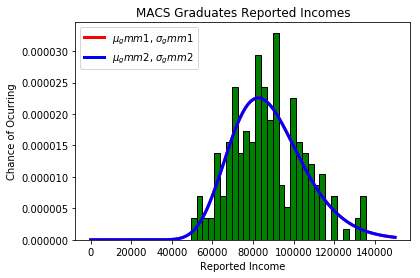

In [17]:
x_sim2 = np.linspace(.01, 150000, 2000)

x_sim2_lognorm = lognormalpdf(x_sim2, gmm_mu2, gmm_sigma2, cutoff)


plt.hist(incomes, bins = 30, normed = 30, color = 'g', edgecolor = 'black')
plt.title("MACS Graduates Reported Incomes")
plt.xlabel("Reported Income")
plt.ylabel("Chance of Ocurring")
plt.plot(x_sim, x_sim_pdf, linewidth = 3, color = 'r', label='$\mu_gmm1$, $\sigma_gmm1$')
plt.plot(x_sim2, x_sim2_lognorm, linewidth = 3, color = 'b', label='$\mu_gmm2$, $\sigma_gmm2$' )
plt.legend(loc = 'upper left')

In [18]:
model_mean2, model_std2 = modelMoments(gmm_mu2, gmm_sigma2, cutoff)
print("Data Mean: ", data_mean)
print("Data Standard Deviation: ", data_std)
print("-----------------------------------")
print("Model #1 Mean: ", model_mean)
print("Model #1 Standard Deviation: ", model_std)
print("-----------------------------------")
print("Model #2 Mean: ", model_mean2)
print("Model #2 Standard Deviation: ", model_std2)

Data Mean:  87588.93076851233
Data Standard Deviation:  18081.166388410416
-----------------------------------
Model #1 Mean:  87588.93068826331
Model #1 Standard Deviation:  18081.1676079
-----------------------------------
Model #2 Mean:  87588.9244489748
Model #2 Standard Deviation:  18081.1663123


d) Now estimate the lognormal PDF to fit the data by GMM using different moments. Use percent of individuals who earn less than \$75,000, percent of individuals who earn between \$75,000 and \$100,000, and percent of individuals who earn more than \$100,000 as your three moments. 

Use the identity matrix as your estimator for the optimal weighting matrix. 

Plot your estimated lognormal PDF against the histogram from part (a). 

Report the value of your GMM criterion function at the estimated parameter values. 

Report and compare your three data moments against your three model moments at the estimated parameter values.

In [19]:
def dataMoments2(x):
    data_prct_under75 = x[x<75000].shape[0]/x.shape[0]
    data_prct_75_100 = x[(x>=75000) & (x<=100000)].shape[0]/x.shape[0]
    data_prct_over100 = x[x>100000].shape[0]/x.shape[0]
    
    return(data_prct_under75, data_prct_75_100, data_prct_over100)

In [20]:
def modelMoments2(mu, sigma, cutoff):
    xfx = lambda x: lognormalpdf(x, mu, sigma, cutoff)
    (model_prct_under75, model_under75_err) = intgr.quad(xfx, 0.01, 75000)
    (model_prct_75to100, model_prct_75to100_err) = intgr.quad(xfx, 75000,100000)
    (model_prct_over100, model_prct_over100_err) = intgr.quad(xfx, 100000, np.inf)
    
    return(model_prct_under75,
           model_prct_75to100,
           model_prct_over100)    

In [21]:
def errorVector2(x, mu, sigma, cutoff, simple):
    data_prct_under75, data_prct_75_100, data_prct_over100 = dataMoments2(x)
    
    data_moments = np.array([[data_prct_under75],[data_prct_75_100],[data_prct_over100]])
    
    model_prct_under75, model_prct_75to100, model_prct_over100 = modelMoments2(mu, sigma, cutoff)
    
    model_moments = np.array([[model_prct_under75],[model_prct_75to100],[model_prct_over100]]) 
    
    if simple:
        errorVector = model_moments - data_moments
    else:
        errorVector = 100 * ((model_moments - data_moments) / data_moments)
    
    return(errorVector)

In [22]:
def crit2(params, *args):
    mu, sigma = params
    x, cutoff, w = args
    errors2 = errorVector2(x, mu, sigma, cutoff, simple = False)
    criticalValue = np.dot(np.dot(errors2.T, w), errors2)
    return(criticalValue)

In [23]:
d_under75, d_75to100, d_over100 = dataMoments2(incomes)
m_under75, m_75to100, m_over100 = modelMoments2(11,.5, cutoff)

data_mu3, data_sigma3 = dataMoments(incomes)

print('-----------------------------------------------------------------------------')
print("Data Moments:")
print('-----------------------------------------------------------------------------')
print("Data Mu: ", data_mu3)
print("Data Sigma: ", data_sigma3)
print("")

print('-----------------------------------------------------------------------------')
print("Actual Data:")
print('-----------------------------------------------------------------------------')
print("Percent Making Under $75,000: ", d_under75)
print("Percent Making between $75,000 & $100,000 : ", d_75to100)
print("Percent Making Over $100,000: ", d_over100)
print("")


print('-----------------------------------------------------------------------------')
print("Model Data:")
print('-----------------------------------------------------------------------------')
print("Percent Making Under $75,000: ", m_under75)
print("Percent Making between $75,000 & $100,000 : ", m_75to100)
print("Percent Making Over $100,000: ", m_over100)
print("")

print('-----------------------------------------------------------------------------')
print("Criterion:")
print('-----------------------------------------------------------------------------')

init_mu3 = 11.25
init_sigma3 = .3
params3 = np.array([init_mu3, init_sigma3])
w_hat3 = np.eye(3)

gmm_args3 = (incomes,
             cutoff,
             w_hat3)

criterion2 = crit2(params3, incomes, cutoff, w_hat3)
print(criterion2)

-----------------------------------------------------------------------------
Data Moments:
-----------------------------------------------------------------------------
Data Mu:  87588.93076851233
Data Sigma:  18081.166388410416

-----------------------------------------------------------------------------
Actual Data:
-----------------------------------------------------------------------------
Percent Making Under $75,000:  0.265
Percent Making between $75,000 & $100,000 :  0.475
Percent Making Over $100,000:  0.26

-----------------------------------------------------------------------------
Model Data:
-----------------------------------------------------------------------------
Percent Making Under $75,000:  0.6738202596154482
Percent Making between $75,000 & $100,000 :  0.17369881270011803
Percent Making Over $100,000:  0.1524809276844328

-----------------------------------------------------------------------------
Criterion:
----------------------------------------------------

In [24]:
results3 = opt.minimize(crit2, params3, args = (gmm_args3), method='L-BFGS-B', bounds=((0.1, None), (0.1, None)))
gmm_mu3, gmm_sigma3 = results.x
print("--------------------------------------------------------")
print("Model #3 Mu: ", gmm_mu3)
print("--------------------------------------------------------")
print("Model #3 Standard Deviation: ", gmm_sigma3)
print("--------------------------------------------------------")
print("Model #3 Results:")
print(results3)
print(("--------------------------------------------------------"))

--------------------------------------------------------
Model #3 Mu:  11.3661009481
--------------------------------------------------------
Model #3 Standard Deviation:  0.209359943669
--------------------------------------------------------
Model #3 Results:
      fun: array([[  2.52645502e-11]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.42517292e-04,  -7.53677104e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 39
      nit: 10
   status: 0
  success: True
        x: array([ 11.36734892,   0.22628052])
--------------------------------------------------------


/Users/thomascurran/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


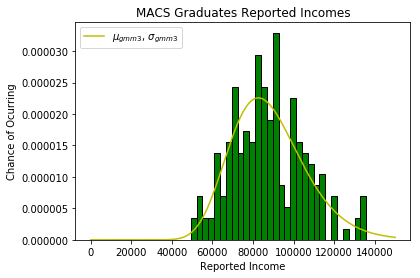

In [25]:
x_sim3 = np.linspace(.01, 150000, 2000)

x_sim3_lognorm = lognormalpdf(x_sim3, gmm_mu3, gmm_sigma3, cutoff)


plt.hist(incomes, bins = 30, normed = 30, color = 'g', edgecolor = 'black')
plt.title("MACS Graduates Reported Incomes")
plt.xlabel("Reported Income")
plt.ylabel("Chance of Ocurring")
plt.plot(x_sim3, x_sim3_lognorm, color = 'y', label='$\mu_{gmm3}$, $\sigma_{gmm3}$' )
plt.legend(loc = 'upper left')

***
e) Perform the two-step GMM estimator by using your estimates from part (d) with three moments to generate an estimator for the variance covariance matrix Ωˆ2step, which you then use to get the two-step estimator for the optimal weighting matrix Wˆ 2step. 

Report your estimates as well as the criterion function value at these estimates. Plot your estimated lognormal PDF against the histogram from part (a) and the estimated PDF from part (d). 

Report and compare your three data moments against your

three model moments at the estimated parameter values.

In [26]:
#errors1(x, mu, sigma, cutoff, simple)
error3 = errorVector2(incomes, gmm_mu3, gmm_sigma3, cutoff, False)
print("critical values of error functions: ", error1)
print("----------------------------------------------")

varcovmatrix3 = np.dot(error3, error3.T)/incomes.shape[0]
print("Variance Covariance Matrix:")
print(varcovmatrix3)

print("----------------------------------------------")
print("Two Step Optimal Weighting Matrix: ")
w_hat3 = lin.pinv(varcovmatrix3)
print(w_hat3)

critical values of error functions:  [[ -9.16200531e-10]
 [  6.74459968e-08]]
----------------------------------------------
Variance Covariance Matrix:
[[ 0.14893467 -0.18904284  0.19356793]
 [-0.18904284  0.23995215 -0.24569585]
 [ 0.19356793 -0.24569585  0.25157703]]
----------------------------------------------
Two Step Optimal Weighting Matrix: 
[[ 0.36308354 -0.46086208  0.47189367]
 [-0.46086208  0.58497244 -0.59897483]
 [ 0.47189367 -0.59897483  0.61331239]]


In [31]:
init_mu4 = 11.5
init_sigma4 = .5
params4 = np.array([init_mu4, init_sigma4])
w_hat4 = np.eye(3)

gmm_args4 = (incomes,
             cutoff,
             w_hat4)

criterion4 = crit2(params4, incomes, cutoff, w_hat3)
results4 = opt.minimize(crit2, params4, args = (gmm_args4), method='L-BFGS-B', bounds=((0.1, None), (0.1, None)))
print(criterion4)

gmm_mu4, gmm_sigma4 = results4.x
print(results4.x)

/Users/thomascurran/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


[[ 13547.24263482]]
[ 11.36734892   0.22628052]


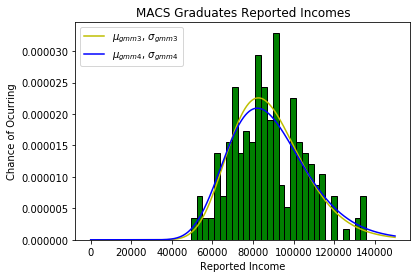

In [32]:
x_sim4 = np.linspace(.01, 150000, 2000)
x_sim4_lognorm = lognormalpdf(x_sim4, gmm_mu4, gmm_sigma4, cutoff)
plt.hist(incomes, bins = 30, normed = 30, color = 'g', edgecolor = 'black')
plt.title("MACS Graduates Reported Incomes")
plt.xlabel("Reported Income")
plt.ylabel("Chance of Ocurring")
plt.plot(x_sim3, x_sim3_lognorm, color = 'y', label='$\mu_{gmm3}$, $\sigma_{gmm3}$' )
plt.plot(x_sim4, x_sim4_lognorm, color = 'b', label='$\mu_{gmm4}$, $\sigma_{gmm4}$' )
plt.legend(loc = 'upper left')

f) Which of the four estimations from parts (b), (c), (d), and (e) fits the data best? Justify your answer.

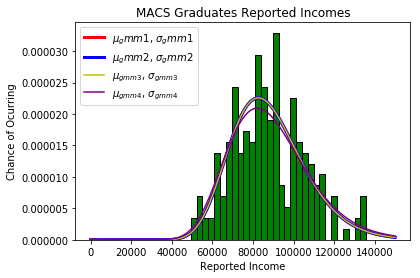

In [44]:
plt.hist(incomes, bins = 30, normed = 30, color = 'g', edgecolor = 'black')
plt.title("MACS Graduates Reported Incomes")
plt.xlabel("Reported Income")
plt.ylabel("Chance of Ocurring")
plt.plot(x_sim, x_sim_pdf, linewidth = 3, color = 'r', label='$\mu_gmm1$, $\sigma_gmm1$')
plt.plot(x_sim2, x_sim2_lognorm, linewidth = 3, color = 'b', label='$\mu_gmm2$, $\sigma_gmm2$' )
plt.plot(x_sim3, x_sim3_lognorm, color = 'y', label='$\mu_{gmm3}$, $\sigma_{gmm3}$' )
plt.plot(x_sim4, x_sim4_lognorm, color = 'purple', label='$\mu_{gmm4}$, $\sigma_{gmm4}$' )
plt.legend(loc = 'upper left')

In [42]:
print("Criterion Function Values")

print("Model #1 - ", results.fun[0])
print("Model #2 - ", results.fun[0])
print("Model #3 - ", results3.fun[0])
print("Model #4 - ", results4.fun[0])

Criterion Function Values
Model #1 -  [  4.54980191e-15]
Model #2 -  [  4.54980191e-15]
Model #3 -  [  2.52645502e-11]
Model #4 -  [  2.41103406e-11]


based on the given models from b, c, d and e I would choose either the model from part b or part c since they have the lower values of the criterion function. 